## Modificación de la ecuación de Tait, la velocidad de sonido artificial y la viscosidad.

Haciendo una revisión superficial con ChatGPT encontramos los siguientes errores pequeños que pueden producir inestabilidades numéricas y que no permiten el uso de los valores realistas de B,c. Haremos un estudio detallado de como estos valores se representan en la literatura y haremos las correcciones necesarias para llevar a cabo la implementación con valores que tengan sentido físico.

- Viscosidad artificial demasiado débil (α,β ≪ 0.1)

- c grande con Δt probablemente demasiado grande

- Uso de c constante desacoplado de la EOS

- Presión rígida en fronteras

- $\epsilon^2$ demasiado pequeño en $\phi_{ij}$


### 1. Valores de $\alpha$ y $\beta$ encontrados en la literatura.

Encontramos en Becker & Teschenner (2007) que usan un modelo lineal para la viscosidad artificial que solo depende de un parámetro $\alpha$.

$\Pi_{ab}$ =
\begin{cases}
-\nu \dfrac{\mathbf{v}_{ab}\cdot\mathbf{x}_{ab}}
{|\mathbf{x}_{ab}|^2 + \varepsilon h^2},
& \text{si } \mathbf{v}_{ab}\cdot\mathbf{x}_{ab} < 0, \\[8pt]
0,
& \text{si no}.
\end{cases}

Donde

$$ \nu = \frac{2 \alpha h c_s}{\rho_a + \rho_b} $$

Y:

$$ \alpha \in [0.08, 0.5],\ \epsilon = 0.01 $$

Hacemos los cambios necesarios para incluir esta nueva función dentro de los códigos hasta ahora trabajados.

**Según se entiende WCSPH no trabaja con la energía interna solo con las ecuaciones de conservación de la masa y del momentum**

### 2. Valor del $\Delta t$ basado en Becker & Teschner (2007).

Anteriormente, habíamos determinado que el valor de $\Delta t$ estaba asociado a los parámetros de $\alpha$ y $\beta$, y que rondaba los $3.5 \times 10^{-5}\ s$. Ahora, que existe uno solo de esos parámetros haremos uso de la ecuación:

$$ \Delta t = min \left( 0.25 \cdot min \left(\frac{h}{|f_a|} \right), 0.4\ \cdot \frac{h}{c_s\ (1 + 0.6\alpha)} \right) $$

Donde $f_a$ denota fuerzas externas.

Para hallar la velocidad de sonido artificial tenemos que:

$$ c_s \geq \frac{v_{max}}{\sqrt{\eta}} $$

Donde $\eta = 0.01$, $v_{max} = \sqrt{2 \cdot (9.8m/s^2)\ (0.1m)} = 1.4\ m/s$.

Pues la velocidad máxima que alcanza es en el vaciado de tanque correspondiente a la caída del agua.

Por lo que tenemos que $c_s \approx 10\ v_{max} = 14\ m/s$


In [4]:
h = 2.75e-3
mass = 6.25e-3
fa = 9.8*mass
c_s = 14
alpha = 0.1

import numpy as np

delta_t = min(0.25 * h/(fa),0.4*h/(c_s*(1+0.6*alpha)))

print(delta_t)

7.412398921832884e-05


Seguimos aún en el orden de $7.4 \times 10^{-5}$, por lo que podemos decir, que el tiempo de integración no se encontraba mal anteriormente.

### 3. Uso de c como una constante desacoplada de la EOS.
### 4. Presión rígida en fronteras.

Basado en la recomendación de ChatGPT se debería hacer uso de una velocidad del sonido variable, podemos comparar la ecuación que este nos dió correspondiente a:

$$ c = \sqrt{\gamma \frac{p}{\rho}} $$

Con la ecuación que se encuentra en Eirís, A. Ramírez, L. et al (2021) :
![Captura desde 2025-12-22 21-04-00.png](<attachment:Captura desde 2025-12-22 21-04-00.png>)
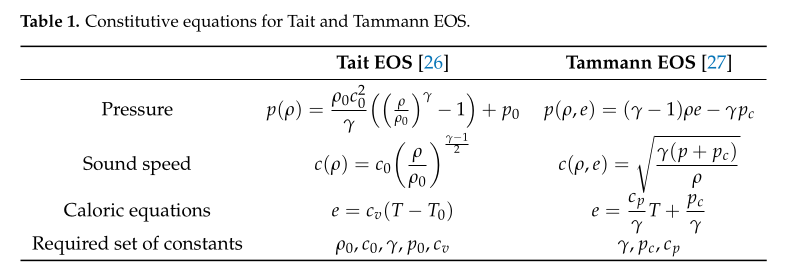

También, se tiene que sobre la frontera si se necesita hacer un cálculo de presión ya que esta se extrapola desde el fluido y por lo tanto, cambia con el tiempo.

Siguiendo la referecia de Adami, S. (2012) tenemos que la presión que experimentan las partículas de frontera están dadas por:

$$ p_w = \frac{\sum_f p_f W_{wf} + (\vec{g} - \vec{a_w}) \cdot \sum_f \rho_f \vec{r}_{wf} W_{wf}}{\sum_f W_{wf}} $$

**Nota:** Leer adecuadamente la sección 4. Solid wall boundary

Donde la aceleración de la frontera en este caso es 0 $\vec{a_w} = 0$.

También se añade dentro de las ecuaciones de Navier-Stockes el aporte de presión que estas hacen al fluido pues esto es la repulsión misma, por lo que se elimina el cálculo del potencial de Lenard-Jones.


**Nota:** Por ahora no hacemos una modificación sobre el valor de c, y se sigue pasando como parámetro.

### 5. El $\epsilon$ de $\phi_{ij}$ ya no existe pues se modificó la función de densidad.

### Prueba: Antes de hacer una modificación de c como variable, es necesario verificar que el modelo de viscosidad y presión en las fronteras funcionan correctamente.

Vamos a calcular los parámetros necesarios, primero hay que tener en cuenta que como prueba de estabilización usando el cuarto de vaso centrado la velocidad de caida máxima es de medio vaso, es decir, de 0.5 m, pero como la parte más alta del fluido está por encima y luego vamos a dejar caer en otro vaso usemos la altura máxima posible que en este caso es de 1m, luego:

$$ v_{max} = \sqrt{2\cdot 9.8 m/s^2\cdot 0.1 m} = 1.4 m/s $$

Como se tiene que la velocidad del sonido es de 10 veces esta velocidad máxima entonces $c_s = 14 m/s$. Y por lo tanto, el parámetro de presión será:

$$ B = \frac{\rho_0\ c^2}{\gamma} = \frac{1000 kg/m^2\ (14\ m/s)^2}{7} \approx \ 28kPa $$

Hagamos una prueba de funcionamiento de estos valores, donde los parámetros importantes acá son:

- h = 2.75e-3
- dx = dy = 2.5e-3
- dt = 7.4e-5

Para determinar el valor de $\alpha$ hacemos uso de las referencias en las cuales tenemos que este valor está entre 0.08 y 0.5. Usaremos $\alpha=0.1$ porque con este calculamos el dt anterior, sin embargo, este valor fue originalmente pensado para una dimensión mayor, con altura de H = 5 y 130 mil partículas de fluido, con un espaciado de dx = dy = 0.1.

La relación entre altura del sistema y espaciado es de 1:50 en el artículo de Becker, mientras en el nuestro es de 1:40.


In [5]:
from utils.create_ics import create_ics_txt
from pathlib import Path

PROJECT_ROOT = Path("/media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH")

FLUID_JSON = f"{PROJECT_ROOT}/Config/parameters/Glass10cmFall/Fluid_estGlass10cmCenter.json"
BOUND_JSON = f"{PROJECT_ROOT}/Config/parameters/Glass10cmFall/Bound_estGlass10cmCenter.json"
OUTPUT_GLASS_DIR = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab"

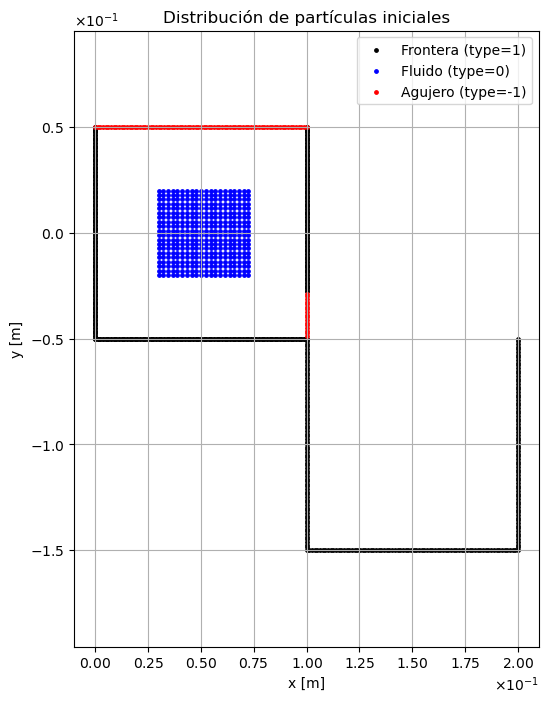

In [6]:
from utils.plot_ics import plot_ics

CENTER_GLASS_ICS = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab/ics/glass10cm_center.txt"

plot_ics(CENTER_GLASS_ICS)

In [16]:
from utils.create_simJSON import create_simulation_config

create_simulation_config(
        experiment_name="Glass10cm_05x05_Adami_Becker",
        input_file=CENTER_GLASS_ICS,
        base_json="Adami_Becker.json",
        B=28e3,
        c=14,
        dt=7.4e-5,
        alpha=1e-3,
        g=-9.8,
        steps=4000,
        project_dir=f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab",
        neighbor_method="quadtree",
        project_root=PROJECT_ROOT
    )

✅ params.json generado: Glass10cm_05x05_Adami_Becker/params.json


PosixPath('/media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_05x05_Adami_Becker/params.json')

In [17]:
from utils.run_sim import run_single_simulation

run_single_simulation(
    experiment_dir=PROJECT_ROOT / "Output" / "Glass10cmFallCenterEstab" / "Glass10cm_05x05_Adami_Becker",
    sim_executable=PROJECT_ROOT / "simAdamiBecker",
    timeout_seconds=10000
)


🚀 Ejecutando simulación: Glass10cm_05x05_Adami_Becker



[INFO] Leyendo parámetros desde: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_05x05_Adami_Becker/params.json
[INFO] Configurada EoS Adami con parámetros:
       B=28000, c=14, rho0=1000, gamma=7
Dentro de función de lectura de partículas
Separación dx/dy de frontera: 0, 0
Separación dx/dy de fluido: 0, 0
Primera partícula de frontera:
  ID: 0 pos: (0, 0.05)
  tipo: Frontera
 h: 0.00275
Última partícula de fluido:
  ID: 1183 pos: (0.0725, 0.02)
  tipo: Fluido
 h: 0.00275
Se leyeron 1184 partículas desde el archivo /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/ics/glass10cm_center.txt

[particleSummary] Número total de partículas: 1184
Fluido: 400, Ancho: 0.0425, Altura: 0.04
Frontera: 784, Ancho: 0.2, Altura: 0.2
[INFO] Ejecutando test del kernel...
Prueba del kernel completada.
Resultados guardados en: Output/tests/kernel_test.output
[findNeighborsQuadTree] Bus

In [18]:
from utils.create_gnuplot import generar_script_gnuplot

BASE_PLOT = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab/Glass10cm_05x05_Adami_Becker"
BASE_FILE = f"{BASE_PLOT}/Output/state_0000.txt"

generar_script_gnuplot(BASE_FILE,
                       lim=4000,
                       retardo=0.01,
                       nombre_salida="plot_est_glass10cm_20x20.gp",
                       ruta_salida=BASE_PLOT
                       )

✅ Script Gnuplot generado correctamente: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_05x05_Adami_Becker/plot_est_glass10cm_20x20.gp
📊 Rangos consecutivos detectados por tipo:
  Tipo 1: líneas 0–223 (224 partículas)
  Tipo -1: líneas 224–321 (98 partículas)
  Tipo 1: líneas 322–783 (462 partículas)
  Tipo 0: líneas 784–1183 (400 partículas)


Hagamos ahora la comparación con la geometría llena de fluido, recortando solo un pedazo del fluido de la superficie.

In [48]:
from utils.create_ics import create_ics_txt
from pathlib import Path

PROJECT_ROOT = Path("/media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH")

FLUID_JSON_F = f"{PROJECT_ROOT}/Config/parameters/Glass10cmFall/Fluid_estGlass10cm90ppFull.json"
BOUND_JSON_F = f"{PROJECT_ROOT}/Config/parameters/Glass10cmFall/Bound_estGlass10cm90ppFull.json"
OUTPUT_GLASS_DIR = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab"

create_ics_txt(
    boundary_path=BOUND_JSON_F,
    fluid_path=FLUID_JSON_F,
    output_path=f"{OUTPUT_GLASS_DIR}/ics/glass10cm_90ppfull.txt",
    output_log_path=f"{OUTPUT_GLASS_DIR}/ics/glass10cm_90ppfull.log"
)

[INFO] Ejecutando main.py con rutas absolutas:
  main.py:      /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/InitialConditions/main.py
  boundary:     /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Config/parameters/Glass10cmFall/Bound_estGlass10cm90ppFull.json
  fluid:        /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Config/parameters/Glass10cmFall/Fluid_estGlass10cm90ppFull.json
  output txt:   /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppfull.txt
  output log:   /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppfull.log

[✓] Ejecución completada correctamente.



0

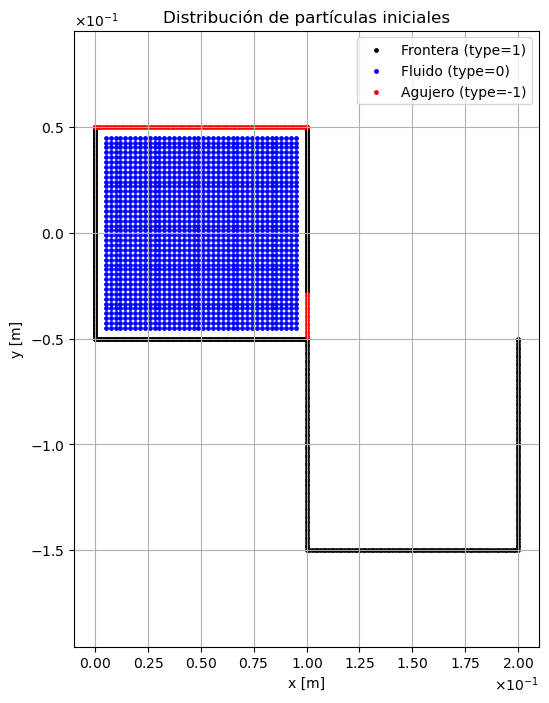

In [49]:
from utils.plot_ics import plot_ics

FULL90PP_GLASS_ICS = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppfull.txt"

plot_ics(FULL90PP_GLASS_ICS)

In [50]:
from utils.create_simJSON import create_simulation_config

create_simulation_config(
        experiment_name="Glass10cm_Adami_Becker",
        input_file=FULL90PP_GLASS_ICS,
        base_json="Adami_Becker.json",
        B=28e3,
        c=14,
        dt=7.4e-5,
        alpha=1e-3,
        g=-9.8,
        steps=4000,
        project_dir=f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab",
        neighbor_method="brute_force",
        project_root=PROJECT_ROOT
    )

✅ params.json generado: Glass10cm_Adami_Becker/params.json


PosixPath('/media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_Adami_Becker/params.json')

In [52]:
from utils.run_sim import run_single_simulation

run_single_simulation(
    experiment_dir=PROJECT_ROOT / "Output" / "Glass10cmFallCenterEstab" / "Glass10cm_Adami_Becker",
    sim_executable=PROJECT_ROOT / "simAdamiBecker",
    timeout_seconds=10000
)


🚀 Ejecutando simulación: Glass10cm_Adami_Becker

[INFO] Leyendo parámetros desde: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_Adami_Becker/params.json
[INFO] Configurada EoS Adami con parámetros:
       B=28000, c=14, rho0=1000, gamma=7
Dentro de función de lectura de partículas
Separación dx/dy de frontera: 0, 0
Separación dx/dy de fluido: 0, 0
Primera partícula de frontera:
  ID: 0 pos: (0, 0.05)
  tipo: Frontera
 h: 0.00275
Última partícula de fluido:
  ID: 2383 pos: (0.095, 0.045)
  tipo: Fluido
 h: 0.00275
Se leyeron 2384 partículas desde el archivo /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppfull.txt

[particleSummary] Número total de partículas: 2384
Fluido: 1600, Ancho: 0.09, Altura: 0.09
Frontera: 784, Ancho: 0.2, Altura: 0.2
[INFO] Ejecutando test del kernel...
Prueba del kernel completada.
Resultados guardados en: Output/tests/k

KeyboardInterrupt: 

In [53]:
from utils.create_gnuplot import generar_script_gnuplot

BASE_PLOT = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab/Glass10cm_Adami_Becker"
BASE_FILE = f"{BASE_PLOT}/Output/state_0000.txt"

generar_script_gnuplot(BASE_FILE,
                       lim=4000,
                       retardo=0.01,
                       nombre_salida="plot_est_glass10cm_20x20.gp",
                       ruta_salida=BASE_PLOT
                       )

✅ Script Gnuplot generado correctamente: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_Adami_Becker/plot_est_glass10cm_20x20.gp
📊 Rangos consecutivos detectados por tipo:
  Tipo 1: líneas 0–223 (224 partículas)
  Tipo -1: líneas 224–321 (98 partículas)
  Tipo 1: líneas 322–783 (462 partículas)
  Tipo 0: líneas 784–2383 (1600 partículas)


Ocurre una onda de presión que no es posible de estabilizar por lo que habría que recortar el fluido un poco para evitarla. Se hace un recorte al 90% lo que implica pasar de 40 a 36 partículas y por lo tanto hacer un recorte del fluido por cada lado de 4 partículas por 2.5e-3 x 4 = 0.01.

In [54]:
from utils.create_ics import create_ics_txt
from pathlib import Path

PROJECT_ROOT = Path("/media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH")

FLUID_JSON_S = f"{PROJECT_ROOT}/Config/parameters/Glass10cmFall/Fluid_estGlass10cm90ppSide.json"
BOUND_JSON_F = f"{PROJECT_ROOT}/Config/parameters/Glass10cmFall/Bound_estGlass10cm90ppFull.json"
OUTPUT_GLASS_DIR = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab"

create_ics_txt(
    boundary_path=BOUND_JSON_F,
    fluid_path=FLUID_JSON_S,
    output_path=f"{OUTPUT_GLASS_DIR}/ics/glass10cm_90ppside.txt",
    output_log_path=f"{OUTPUT_GLASS_DIR}/ics/glass10cm_90ppside.log"
)

[INFO] Ejecutando main.py con rutas absolutas:
  main.py:      /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/InitialConditions/main.py
  boundary:     /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Config/parameters/Glass10cmFall/Bound_estGlass10cm90ppFull.json
  fluid:        /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Config/parameters/Glass10cmFall/Fluid_estGlass10cm90ppSide.json
  output txt:   /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppside.txt
  output log:   /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppside.log

[✓] Ejecución completada correctamente.



0

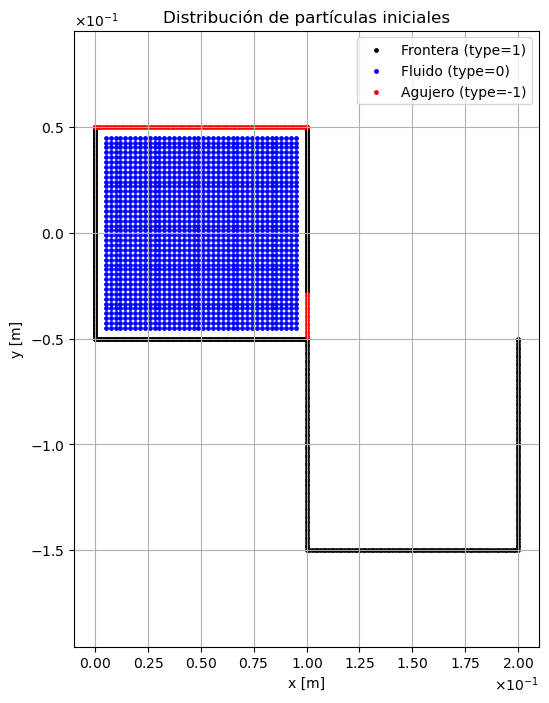

In [59]:
from utils.plot_ics import plot_ics

FULL90PP_GLASS_ICS = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppfull.txt"

plot_ics(FULL90PP_GLASS_ICS)

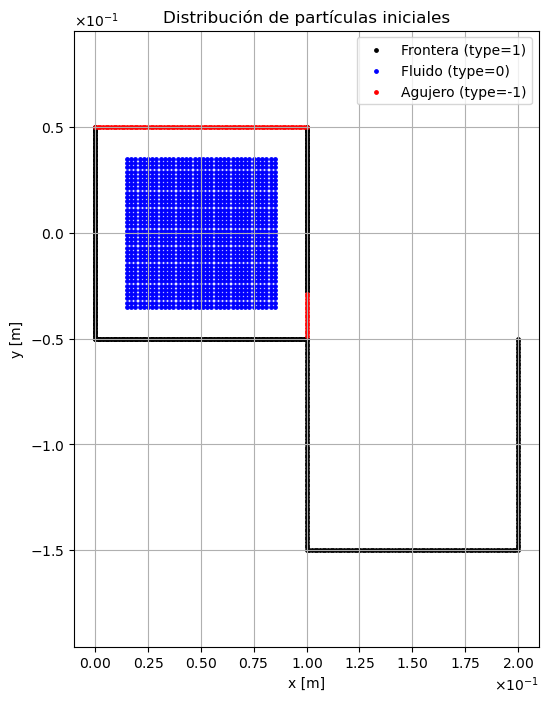

In [57]:
from utils.plot_ics import plot_ics

SIDE90PP_GLASS_ICS = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppside.txt"

plot_ics(SIDE90PP_GLASS_ICS)

In [66]:
from utils.create_simJSON import create_simulation_config

create_simulation_config(
        experiment_name="Glass10cm_Adami_Becker_90pp",
        input_file=SIDE90PP_GLASS_ICS,
        base_json="Adami_Becker.json",
        B=28e3,
        c=14,
        dt=7.4e-6,
        alpha=1e-6,
        g=-9.8,
        steps=4000,
        project_dir=f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab",
        neighbor_method="brute_force",
        project_root=PROJECT_ROOT
    )

✅ params.json generado: Glass10cm_Adami_Becker_90pp/params.json


PosixPath('/media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_Adami_Becker_90pp/params.json')

In [67]:
from utils.run_sim import run_single_simulation

run_single_simulation(
    experiment_dir=PROJECT_ROOT / "Output" / "Glass10cmFallCenterEstab" / "Glass10cm_Adami_Becker_90pp",
    sim_executable=PROJECT_ROOT / "simAdamiBecker",
    timeout_seconds=10000
)


🚀 Ejecutando simulación: Glass10cm_Adami_Becker_90pp

[INFO] Leyendo parámetros desde: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_Adami_Becker_90pp/params.json
[INFO] Configurada EoS Adami con parámetros:
       B=28000, c=14, rho0=1000, gamma=7
Dentro de función de lectura de partículas
Separación dx/dy de frontera: 0, 0
Separación dx/dy de fluido: 0, 0
Primera partícula de frontera:
  ID: 0 pos: (0, 0.05)
  tipo: Frontera
 h: 0.00275
Última partícula de fluido:
  ID: 2079 pos: (0.085, 0.035)
  tipo: Fluido
 h: 0.00275
Se leyeron 2080 partículas desde el archivo /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/ics/glass10cm_90ppside.txt

[particleSummary] Número total de partículas: 2080
Fluido: 1296, Ancho: 0.07, Altura: 0.07
Frontera: 784, Ancho: 0.2, Altura: 0.2
[INFO] Ejecutando test del kernel...
Prueba del kernel completada.
Resultados guardados en: Outp

KeyboardInterrupt: 

In [68]:
from utils.create_gnuplot import generar_script_gnuplot

BASE_PLOT = f"{PROJECT_ROOT}/Output/Glass10cmFallCenterEstab/Glass10cm_Adami_Becker_90pp"
BASE_FILE = f"{BASE_PLOT}/Output/state_0000.txt"

generar_script_gnuplot(BASE_FILE,
                       lim=4000,
                       retardo=0.01,
                       nombre_salida="plot_est_glass10cm_20x20.gp",
                       ruta_salida=BASE_PLOT
                       )

✅ Script Gnuplot generado correctamente: /media/hvarkaed/a2e590e8-6eb4-4da7-a766-06b1247531ca/NeighboorsFloodSPH/Output/Glass10cmFallCenterEstab/Glass10cm_Adami_Becker_90pp/plot_est_glass10cm_20x20.gp
📊 Rangos consecutivos detectados por tipo:
  Tipo 1: líneas 0–223 (224 partículas)
  Tipo -1: líneas 224–321 (98 partículas)
  Tipo 1: líneas 322–783 (462 partículas)
  Tipo 0: líneas 784–2079 (1296 partículas)
